## Loading Training Set

Loading the entire dataset into Pandas is going to be slow, so we can use the following optimizations:

- Ignore the `key` column
- Parse pickup datetime while loading data
- Specify data types for other columns
   - `float32` for geo coordinates
   - `float32` for fare amount
   - `uint8` for passenger count
- Work with a 1% sample of the data (~500k rows)

We can apply these optimizations while using [`pd.read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)

In [9]:
import pandas as pd
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [ ]:
sample_frac = 0.01

selected_cols = 'fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count'.split(',')

dtypes = {
    'fare_amount': 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'passenger_count': 'float32'
}

def skip_row(idx):
    if idx == 0:
        return False  # don't skip the header
    return random.random() > sample_frac

random.seed(42)

df = pd.read_csv('train.csv',usecols=selected_cols,dtype=dtypes, parse_dates=['pickup_datetime'],skiprows=skip_row)

In [ ]:
df.head()

In [ ]:
test_df = pd.read_csv('test.csv',dtype=dtypes, parse_dates=['pickup_datetime'])

## 2. Explore the Dataset

- Basic info about training set
- Basic info about test set
- Exploratory data analysis & visualization
- Ask & answer questions

In [5]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000
mean,11.354059,-72.497063,39.910492,-72.504341,39.934257,1.684983
std,9.811924,11.618246,8.061114,12.074346,9.255058,1.337664
min,-52.000000,-1183.362793,-3084.490234,-3356.729736,-2073.150613,0.000000
25%,6.000000,-73.992020,40.734875,-73.991425,40.733988,1.000000
50%,8.500000,-73.981819,40.752621,-73.980179,40.753102,1.000000
75%,12.500000,-73.967155,40.767036,-73.963737,40.768060,2.000000
max,499.000000,2420.209473,404.983337,2467.752686,3351.403027,208.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552450 entries, 0 to 552449
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        552450 non-null  float32            
 1   pickup_datetime    552450 non-null  datetime64[ns, UTC]
 2   pickup_longitude   552450 non-null  float32            
 3   pickup_latitude    552450 non-null  float32            
 4   dropoff_longitude  552450 non-null  float32            
 5   dropoff_latitude   552450 non-null  float64            
 6   passenger_count    552450 non-null  float32            
dtypes: datetime64[ns, UTC](1), float32(5), float64(1)
memory usage: 19.0 MB


Observations about training data:

- 550k+ rows, as expected
- No missing data (in the sample)
- `fare_amount` ranges from \$-52.0 to \$499.0
- `passenger_count` ranges from 0 to 208
- There seem to be some errors in the latitude & longitude values
- Dates range from 1st Jan 2009 to 30th June 2015
- The dataset takes up ~19 MB of space in the RAM

We may need to deal with outliers and data entry errors before we train our model.

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                9914 non-null   object             
 1   pickup_datetime    9914 non-null   datetime64[ns, UTC]
 2   pickup_longitude   9914 non-null   float32            
 3   pickup_latitude    9914 non-null   float32            
 4   dropoff_longitude  9914 non-null   float32            
 5   dropoff_latitude   9914 non-null   float64            
 6   passenger_count    9914 non-null   float32            
dtypes: datetime64[ns, UTC](1), float32(4), float64(1), object(1)
memory usage: 387.4+ KB


In [7]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974724,40.751041,-73.973663,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252190,40.573143,-74.263245,40.568973,1.000000
25%,-73.992500,40.736125,-73.991249,40.735254,1.000000
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000
max,-72.986534,41.709557,-72.990967,41.696683,6.000000


Some observations about the test set:

- 9914 rows of data
- No missing values
- No obvious data entry errors
- 1 to 6 passengers (we can limit training data to this range)
- Latitudes lie between 40 and 42
- Longitudes lie between -75 and -72
- Pickup dates range from Jan 1st 2009 to Jun  30th 2015 (same as training set)

We can use the ranges of the test set to drop outliers/invalid data from the training set.

### Exploratory Data Analysis and Visualization



Univariate distributions (each column on its own).
1.1 Distribution of `fare_amount`

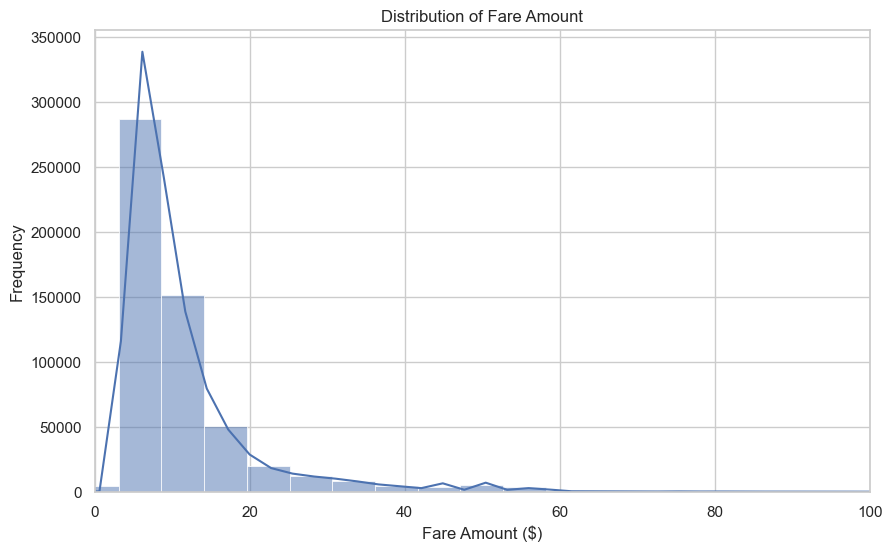

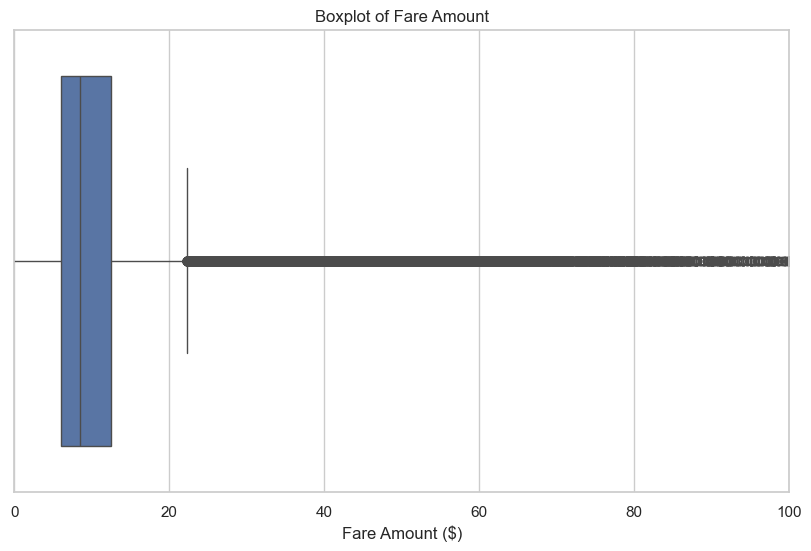

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(df['fare_amount'], bins=100, kde=True)
plt.xlim(0, 100)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x=df['fare_amount'])
plt.xlim(0, 100)
plt.title('Boxplot of Fare Amount')
plt.xlabel('Fare Amount ($)')
plt.show()

Observations about `fare_amount` distribution:
* **Strong right skew:** Most fares are in the low range (roughly 5–20 $), with a long tail toward higher fares. This is typical for real-world price data.

* **Heavy tail / many high outliers:**
  The boxplot shows a *very* long whisker and lots of points far to the right → there are many rides with unusually high fares (e.g. airport / long-distance trips or data errors).

* **Central bulk of data:**
  The densest part of the histogram seems around **7–15 $**, suggesting this is the “typical” NYC taxi fare in your sample.

* **Potential need for transformation:**
  Because the distribution is so skewed, using `log1p(fare_amount)` as a target could help many models (linear models, GBMs) and make residuals more Gaussian.

* **Outlier handling for modeling:**
  For fair prediction tasks,we might :

  * Filter out clearly unrealistic fares (e.g. > 200 $ or < 0 $ if they exist in raw data),
  * Or cap them (winsorization) so that extreme rare trips don’t dominate training.


1.2 Distribution of `passenger_count`


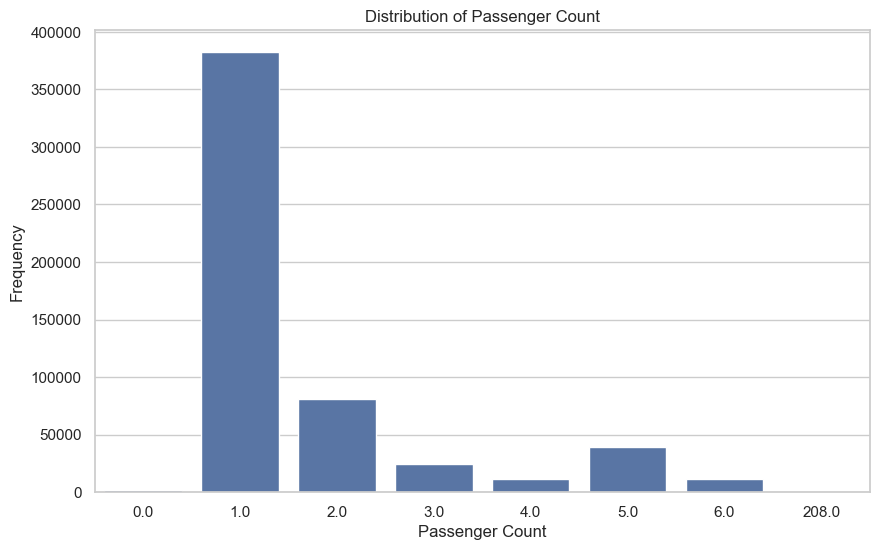

In [11]:
plt.figure(figsize=(10,6))
sns.countplot(x='passenger_count', data=df)
plt.title('Distribution of Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.show()

Observations:
- Most rides have 1 or 2 passengers.
- Very few rides have more than 6 passengers.
- We can consider filtering out rides with more than 6 passengers as they are rare and may not represent typical taxi rides.

1.3 Coordinates: pickup and dropoff locations

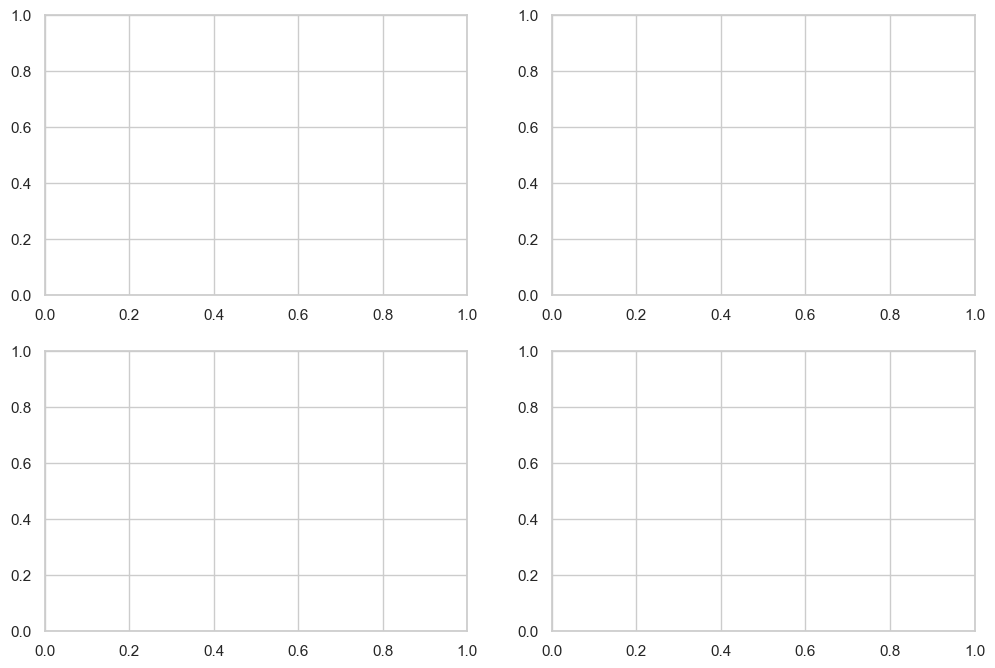

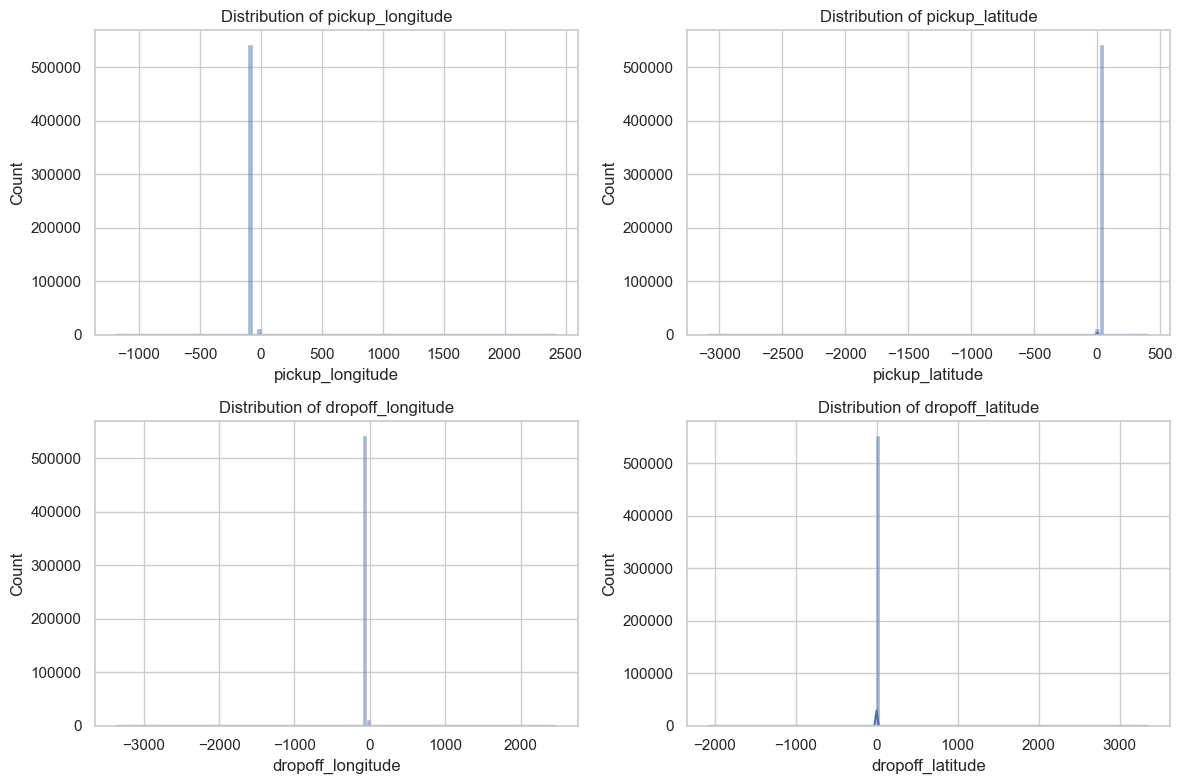

In [13]:
coord_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

fig,axes = plt.subplots(2,2, figsize=(12,8))
for col,ax in zip(coord_cols,axes.flatten()):
    sns.histplot(df[col], bins=100, kde=True, ax=ax)
    ax.set_title(f'Distribution of {col.replace("_"," ").title()}')
    ax.set_xlabel(col.replace("_"," ").title())
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

1.4 Time pickup distribution

In [14]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['pickup_date'] = df['pickup_datetime'].dt.date

Plot number of rides per hour:

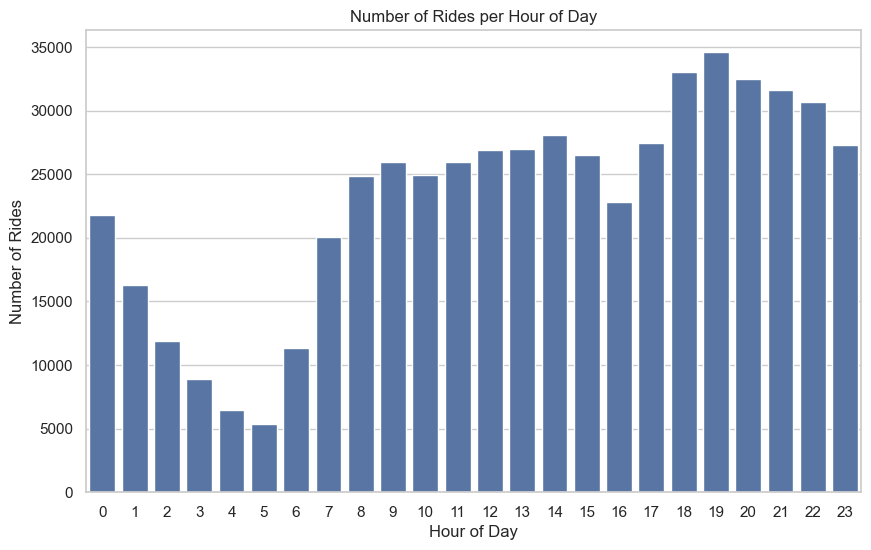

In [15]:
plt.figure(figsize=(10,6))
sns.countplot(x='pickup_hour', data=df)
plt.title('Number of Rides per Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.show()

Rides per weekday:

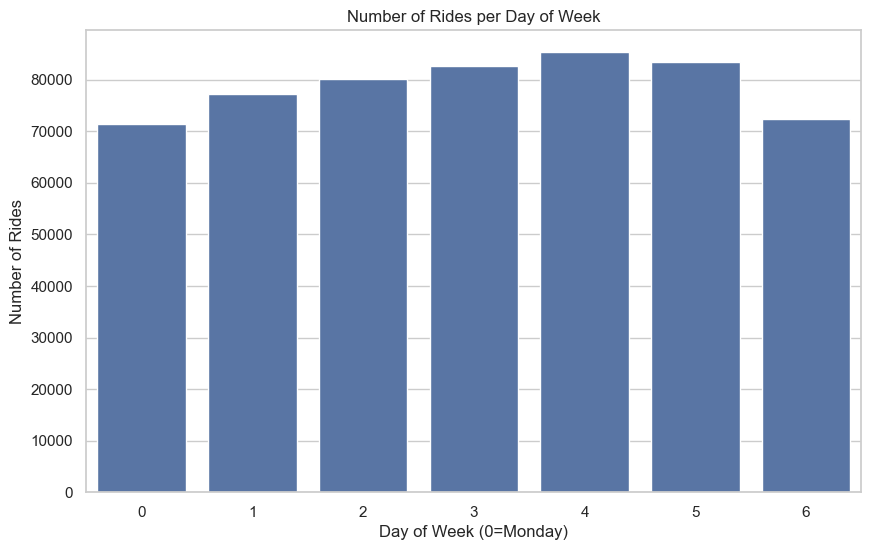

In [16]:
plt.figure(figsize=(10,6))
sns.countplot(x='pickup_dayofweek', data=df)
plt.title('Number of Rides per Day of Week')
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Number of Rides')
plt.show()

## 2. Geospatial visualizations (geo maps)

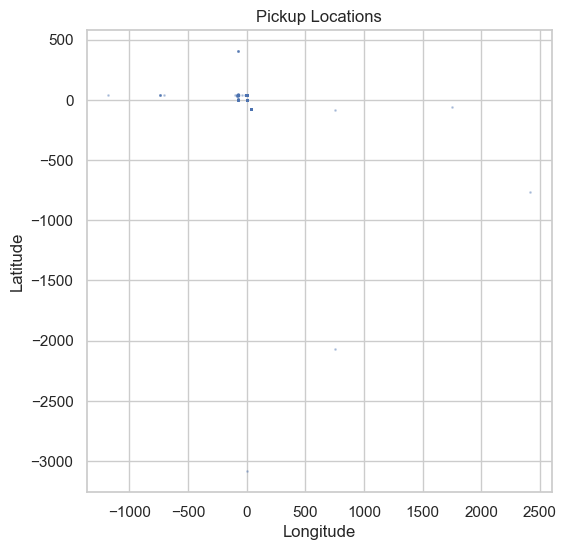

In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(
    df['pickup_longitude'],
    df['pickup_latitude'],
    s=1,
    alpha=0.3
)
plt.title("Pickup Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


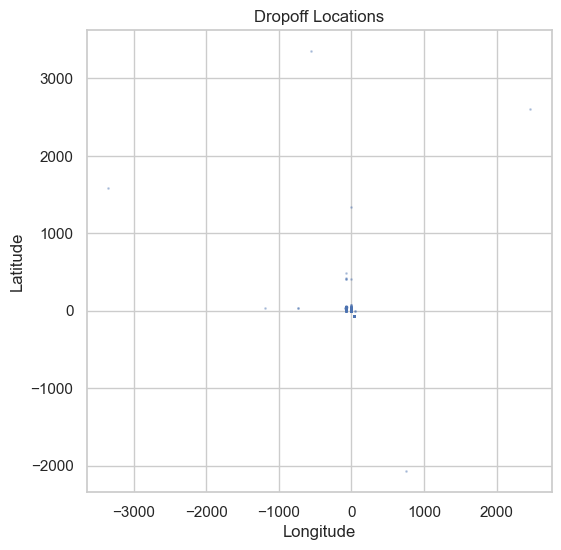

In [18]:
plt.figure(figsize=(6, 6))
plt.scatter(
    df['dropoff_longitude'],
    df['dropoff_latitude'],
    s=1,
    alpha=0.3
)
plt.title("Dropoff Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


### 3. Derived feature: approximate trip distance

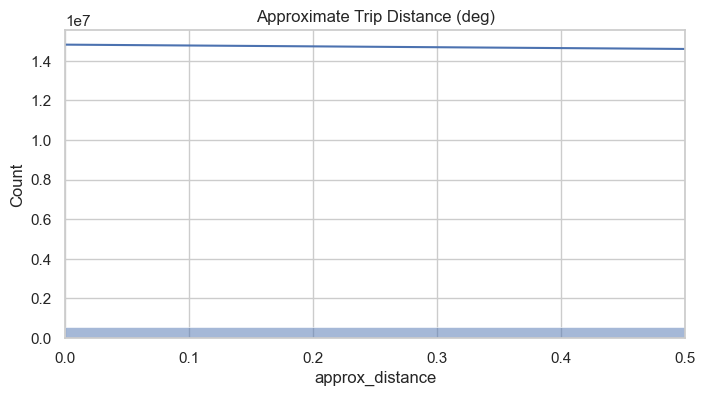

In [19]:
import numpy as np

# very rough Manhattan-like distance in degrees (not km, but correlated)
df['lon_diff'] = (df['dropoff_longitude'] - df['pickup_longitude']).abs()
df['lat_diff'] = (df['dropoff_latitude'] - df['pickup_latitude']).abs()
df['approx_distance'] = df['lon_diff'] + df['lat_diff']

plt.figure(figsize=(8, 4))
sns.histplot(df['approx_distance'], bins=100, kde=True)
plt.xlim(0, 0.5)   # cut off crazy long trips
plt.title("Approximate Trip Distance (deg)")
plt.show()


* **Extreme concentration near 0:**
  Almost all trips have a very small `approx_distance` (close to 0). That means most rides are **short**, as expected for inner-city rides.

* **Very few longer trips:**
  Beyond about **0.2–0.3 degrees**, the histogram is almost flat/empty → long trips (e.g. airport or out-of-city) are rare compared to short ones.

* **Strongly right-skewed distribution:**
  Just like the fares, distances are heavily skewed: a big mass of short trips and a long thin tail of longer distances.

* **Scale note:**
  The y-axis uses scientific notation (`1e7` at the top), so the absolute numbers look huge. That’s just matplotlib’s way of scaling; what matters for us is the **shape** (big spike near 0, quickly dropping off).

* **Implication for modeling / cleaning:**

  * This confirms distance will be a *key predictor* for fare.
  * You might want to **zoom** the x-axis even more (e.g. 0–0.2) or try a **log-transform** on distance for some models.
  * Later we should also check if there are any suspiciously large distances (>> 0.5) and consider filtering them as potential errors.


### 4. Relationships: inputs → fare_amount

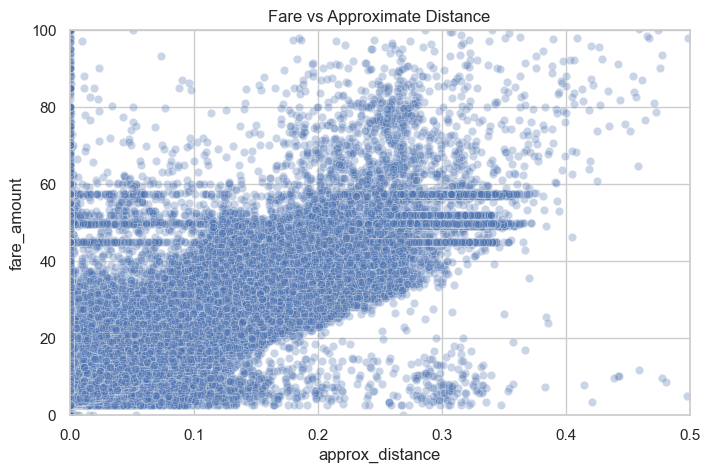

In [24]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x='approx_distance', y='fare_amount',
    alpha=0.3
)
plt.xlim(0, 0.5)
plt.ylim(0, 100)
plt.title("Fare vs Approximate Distance")
plt.show()


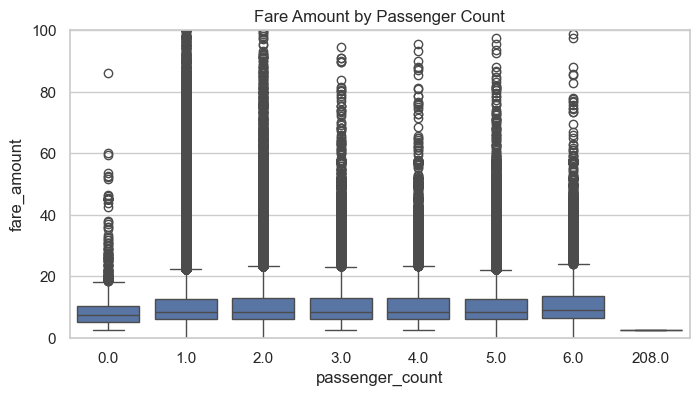

In [25]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='passenger_count', y='fare_amount', data=df)
plt.ylim(0, 100)
plt.title("Fare Amount by Passenger Count")
plt.show()


Fare vs. time features

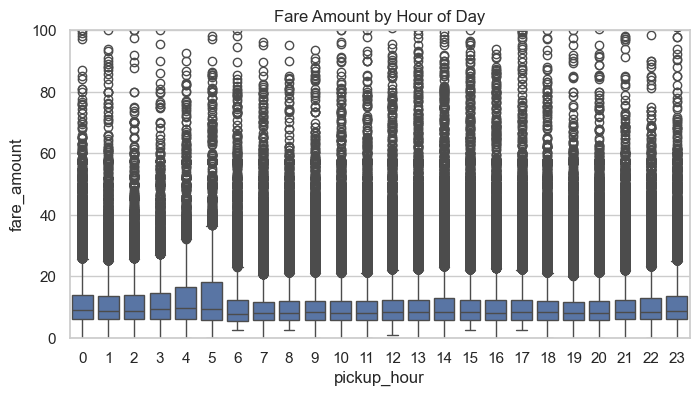

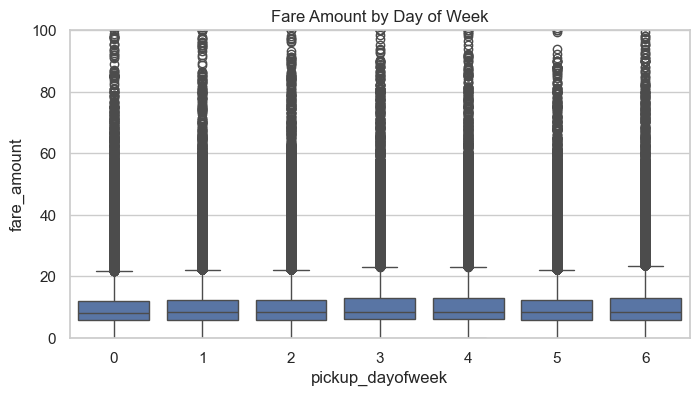

In [27]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='pickup_hour', y='fare_amount', data=df)
plt.ylim(0, 100)
plt.title("Fare Amount by Hour of Day")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x='pickup_dayofweek', y='fare_amount', data=df)
plt.ylim(0, 100)
plt.title("Fare Amount by Day of Week")
plt.show()



Fare vs. coordinates

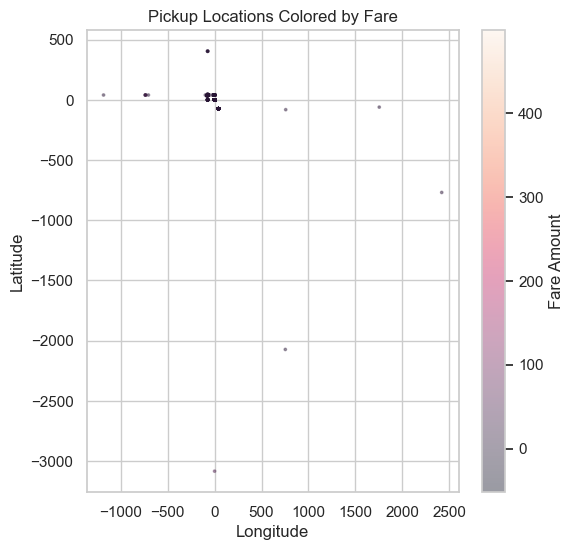

In [29]:
plt.figure(figsize=(6, 6))
plt.scatter(
    df['pickup_longitude'],
    df['pickup_latitude'],
    c=df['fare_amount'],
    s=3,
    alpha=0.4
)
plt.colorbar(label='Fare Amount')
plt.title("Pickup Locations Colored by Fare")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


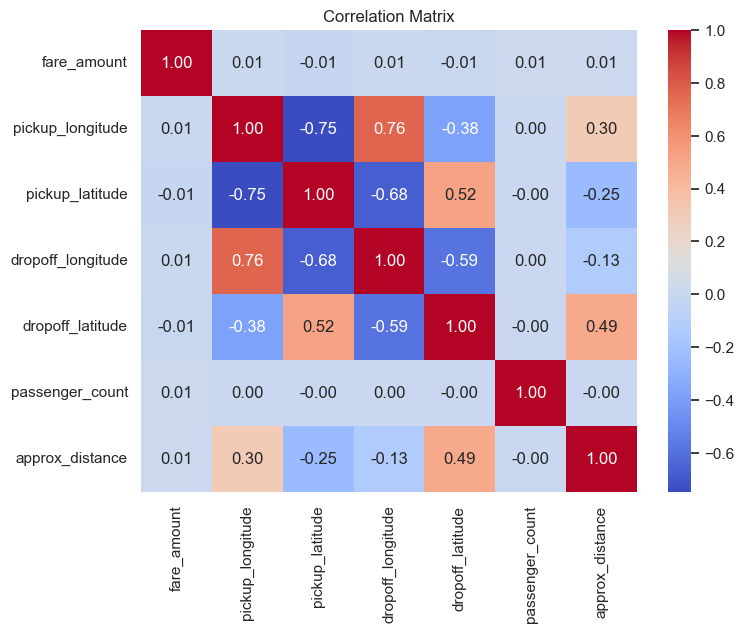

In [30]:
numeric_cols = [
    'fare_amount',
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'passenger_count',
    'approx_distance'
]

corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


The correlation matrix shows that fare_amount has almost no linear correlation with any single feature (values around 0.01), so the relationship between fare and the inputs is likely non-linear and influenced by outliers. The pickup and dropoff coordinates are strongly correlated with each other (e.g. pickup_longitude with dropoff_longitude ≈ 0.76, pickup_latitude with dropoff_latitude ≈ 0.52), reflecting that most trips occur within a compact geographic area where start and end points are relatively close. There are also strong negative correlations between some coordinate pairs (such as pickup_longitude with pickup_latitude ≈ -0.75), which is consistent with the specific spatial layout of the city. The engineered feature approx_distance is moderately correlated with some coordinates (for example with dropoff_latitude and pickup_longitude), indicating that longer trips tend to occur in particular geographic directions. Passenger_count is essentially uncorrelated with all other variables, including fare, suggesting it has limited